## Testing if mutation rate is elevated inside the CDR vs rest of the array

In [11]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np

#### Pseudo code 

```
null_distr = empty list

for rep = 1..1000:
    SNV_rate_fake_CDRs = empty list 
    SNV_rate_outside_fake_CDRs = empty list
    for ref,query in sample pair:
       fake_CDR1 <- random location(s) the same size as the real CDR in ref sample
       fake_CDR2 <- random location(s) the same size as the real CDR in query sample
       SNV_rate_fake_CDRs+= SNV rate in fake CDR1, CDR2
       SNV_rate_outside_fake_CDRs += SNV rate outside fake CDR1, CDR2
    null_distr[rep] <- (mean(SNV_rate_fake_CDRs) - mean(SNV_rate_outside_fake_CDRs))

real_CDR_SNV_rates=empty list
outside_real_CDR_SNV_rates=empty list
for ref,query in sample pair:
    real_CDR_SNV_rates+= inside CDR SNV rates for query sample, ref sample
    outside_real_CDR_SNV_rates += outside CDR SNV rates for query sample, ref sample

test_stat <- (mean(real_CDR_SNV_rates) - mean(outside_real_CDR_SNV_rates))
p_value <- proportion of null_distr that is >test_stat
```
input data to read in:
- list of pairwise comparisons for each chrom (subset to pairs with dist < 0.2)
- SNV calls (bed format, 1 bed for each pair)
- CDR locations for each sample (also bed file)

#### Prepare data tables

- list of pairwise comparisons < 0.2 for each chrom 
- SNV raw mutation files for pairs < 0.2 
- CDR locations 

In [20]:
# Read in list of pairwise distances per chromosome

# Directory containing CSV files
pairwise_dist_dir = "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/"  # this should be a folder path

# Collect all matching files
files = glob.glob(os.path.join(pairwise_dist_dir, "*_r2_QC_v2_centrolign_pairwise_distance.csv"))

all_dfs = []

for f in files:
    # Extract chr from filename
    # e.g. filename: "chr3_r2_QC_v2_centrolign_pairwise_distance.csv"
    basename = os.path.basename(f)
    chr_val = basename.split("_")[0]   # 'chr3'

    # Read CSV
    df = pd.read_csv(f, header=None,names=["sample1", "sample2", "direct_pairwise_dist","chr"])
    df["chr"] = chr_val
    all_dfs.append(df)

# Combine into one dataframe
all_pairs_dist_df = pd.concat(all_dfs, ignore_index=True)

all_pairs_dist_df=all_pairs_dist_df[all_pairs_dist_df["direct_pairwise_dist"]< 0.2]

all_pairs_dist_df["sample_pair"] = (
    all_pairs_dist_df[["sample1", "sample2"]]
    .apply(lambda x: "_".join(sorted(x)), axis=1)
)

all_pairs_dist_df.head()

,sample1,sample2,direct_pairwise_dist,chr,sample_pair
46,HG00741.2,HG01167.2,0.003675,chr6,HG00741.2_HG01167.2
984,NA19700.1,NA19835.1,0.079636,chr6,NA19700.1_NA19835.1
1224,HG02083.2,HG02129.2,0.176519,chr6,HG02083.2_HG02129.2
2003,HG02280.1,NA18879.1,0.134344,chr6,HG02280.1_NA18879.1
2046,HG02258.1,HG03583.2,0.105130,chr6,HG02258.1_HG03583.2


In [13]:
import pandas as pd
from pathlib import Path

BASE_DIR = Path(
    "/private/groups/patenlab/mira/centrolign/analysis/SNVs_induced_pairwise_asm_coords"
)

# set for fast lookup
valid_pairs = set(all_pairs_dist_df["sample_pair"])

dfs = []

for chr_dir in BASE_DIR.iterdir():
    if not chr_dir.is_dir():
        continue
    
    
    chr_name = chr_dir.name
    print(f"Processing {chr_name}..")

    for bed_file in chr_dir.glob("*.bed"):
        # extract samples from filename
        s1, s2 = bed_file.stem.split("_", 1)
        pair_key = "_".join(sorted([s1, s2]))

        # skip if not in allowed pairs
        if pair_key not in valid_pairs:
            continue

        # read BED
        df = pd.read_csv(
            bed_file,
            sep="\t",
            header=None,
            names=["ref_contig", "ref_start", "ref_end","query_contig","query_start","query_end"]  # adjust if more BED columns exist
        )

        df["sample1"] = s1
        df["sample2"] = s2
        df["sample_pair"] = pair_key
        df["chr"] = chr_name

        dfs.append(df)

# combine all chromosomes
SNVs_raw_df = pd.concat(dfs, ignore_index=True)


Processing chr11..


KeyboardInterrupt: 

In [ ]:
SNVs_raw_df.to_parquet("/private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/SNVs_raw_df.parquet")

In [21]:
SNVs_raw_df=pd.read_parquet("/private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/SNVs_raw_df.parquet")

In [22]:
SNVs_raw_df.head()

,ref_contig,ref_start,ref_end,query_contig,query_start,query_end,sample1,sample2,sample_pair,chr
0,HG00673#2#CM089162.1,50983877,50983878,HG02074#1#CM088274.1,50935171,50935172,HG00673.2,HG02074.1,HG00673.2_HG02074.1,chr11
1,HG00673#2#CM089162.1,50990315,50990316,HG02074#1#CM088274.1,50941609,50941610,HG00673.2,HG02074.1,HG00673.2_HG02074.1,chr11
2,HG00673#2#CM089162.1,50990316,50990317,HG02074#1#CM088274.1,50941610,50941611,HG00673.2,HG02074.1,HG00673.2_HG02074.1,chr11
3,HG00673#2#CM089162.1,50991378,50991379,HG02074#1#CM088274.1,50942672,50942673,HG00673.2,HG02074.1,HG00673.2_HG02074.1,chr11
4,HG00673#2#CM089162.1,50991379,50991380,HG02074#1#CM088274.1,50942673,50942674,HG00673.2,HG02074.1,HG00673.2_HG02074.1,chr11


In [23]:
import pandas as pd
from pathlib import Path

ASAT_DIR = Path(
    "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/per_smp_asat_beds"
)

dfs = []

for bed_file in ASAT_DIR.glob("*_asat_arrays.bed"):
    sample = bed_file.name.replace("_asat_arrays.bed", "")

    df = pd.read_csv(
        bed_file,
        sep="\t",
        header=None,
        names=["contig", "start", "end", "chr"]
    )

    df["sample"] = sample
    dfs.append(df)

asat_df = pd.concat(dfs, ignore_index=True)


In [24]:
asat_df.head()

,contig,start,end,chr,sample
0,HG02572#1#CM088151.1,92088720,94028031,chr2,HG02572.1
1,HG02572#1#CM088156.1,60815527,63871369,chr7,HG02572.1
2,HG02572#1#CM088157.1,44232206,46352903,chr8,HG02572.1
3,HG02572#1#CM088158.1,42616238,44955099,chr9,HG02572.1
4,HG02572#1#CM088160.1,50957725,52118575,chr11,HG02572.1


In [25]:
import pandas as pd
from pathlib import Path

BASE_DIR = Path(
    "/private/groups/migalab/jmmenend/HPRC/cenSatProject/CDR_data"
)
dfs = []

for bed_file in BASE_DIR.glob("*/ *.centrodip.bed".replace(" ", "")):
    # chr comes from directory name (and filename, they match)
    chr_name = bed_file.parent.name

    df = pd.read_csv(
        bed_file,
        sep="\t",
        header=None,
        usecols=[0, 1, 2],
        names=["contig", "start", "end"]
    )

    sample_parts = df["contig"].str.split("#", expand=True)
    df["sample"] = sample_parts[0] + "." + sample_parts[1]
    df["chr"] = chr_name
    dfs.append(df)

cdr_df = pd.concat(dfs, ignore_index=True)
cdr_df.head()

,contig,start,end,sample,chr
0,HG00097#1#CM094067.1,52461286,52582524,HG00097.1,chr11
1,HG00097#1#CM094067.1,52595575,52608024,HG00097.1,chr11
2,HG00097#2#CM094082.1,51960327,51997373,HG00097.2,chr11
3,HG00097#2#CM094082.1,52216289,52237877,HG00097.2,chr11
4,HG00097#2#CM094082.1,52242986,52270186,HG00097.2,chr11


### Helper functions 

#### Cigar parsing for SNV aligned bases 

In [26]:
import re

def parse_cigar(cigar):
    """
    Parse a CIGAR string into a list of (length, operation) tuples.

    Example:
        '10M2I5M3D8M' ->
        [(10,'M'), (2,'I'), (5,'M'), (3,'D'), (8,'M')]
    """
    return [
        (int(length), op)
        for length, op in re.findall(r'(\d+)([MIDNSHP=X])', cigar)
    ]

def reverse_cigar(parsed):
    """
    Convert a parsed CIGAR from ref->query into query->ref.

    Insertions become deletions and vice versa.
    Matches, mismatches, and equals stay the same.
    """
    converted = []
    for length, op in parsed:
        if op == "I":
            converted.append((length, "D"))
        elif op == "D":
            converted.append((length, "I"))
        else:
            converted.append((length, op))
    return converted

def build_aligned_intervals_from_ops(cigar_ops, start_pos):
    """
    Build aligned intervals on the genome from parsed CIGAR ops.

    Parameters
    ----------
    cigar_ops : list of (length, op)
        Parsed CIGAR string
    start_pos : int
        Genomic start position of the alignment

    Returns
    -------
    intervals : list of (start, end)
        Genomic intervals where bases are aligned (M, =, X)
    """
    intervals = []
    pos = start_pos

    for length, op in cigar_ops:
        if op in ("M", "=", "X"):
            # Aligned bases
            intervals.append((pos, pos + length))
            pos += length
        elif op in ("D", "N"):
            # Consumes reference but not query
            pos += length
        # Insertions do not consume reference positions

    return intervals

#### Computing overlaps

In [50]:
def aligned_bp(aligned_intervals, query_intervals):
    """
    Compute total aligned bases overlapping query intervals.

    Both aligned_intervals and query_intervals must be:
      - sorted
      - half-open intervals [start, end)

    Uses a two-pointer sweep (O(n + m)).

    Parameters
    ----------
    aligned_intervals : list of (start, end)
        Fixed alignment blocks from CIGAR
    query_intervals : list of (start, end)
        Arbitrary windows (real or fake CDRs, ASAT)

    Returns
    -------
    total_aligned_bp : int
    """
    total = 0
    i = j = 0

    while i < len(aligned_intervals) and j < len(query_intervals):
        a_start, a_end = aligned_intervals[i]
        q_start, q_end = query_intervals[j]

        overlap = min(a_end, q_end) - max(a_start, q_start)
        if overlap > 0:
            total += overlap

        # Advance the interval that ends first
        if a_end < q_end:
            i += 1
        else:
            j += 1

    return total

import numpy as np

def count_snvs_in_intervals(snv_positions, intervals):
    """
    Count SNVs falling inside a list of intervals.

    Parameters
    ----------
    snv_positions : 1D numpy array
        Sorted SNV positions for (sample, chr, sample_pair)
    intervals : list of (start, end)

    Returns
    -------
    n_snvs : int
    """
    total = 0
    for start, end in intervals:
        total += (
            np.searchsorted(snv_positions, end, side="left")
            - np.searchsorted(snv_positions, start, side="left")
        )
    return total

def intervals_overlap(a, b):
    return not (a[1] <= b[0] or a[0] >= b[1])


def random_intervals_like(real_intervals, bounds, rng, max_tries=1000, sample_info=None):
    """
    Sample non-overlapping fake intervals matching the lengths of real_intervals,
    within bounds. Overlaps with real CDRs are allowed, but intervals within
    the same rep do not overlap each other.

    Parameters
    ----------
    sample_info : str, optional
        Info about the sample/pair to include in error messages for debugging.
    """
    fake_intervals = []
    lengths = [end - start for start, end in real_intervals]

    for L in lengths:
        start_min = bounds[0]
        start_max = bounds[1] - L
        if start_max < start_min:
            msg = f"CDR length {L} exceeds ASAT bounds {bounds}"
            if sample_info:
                msg += f" for sample/pair {sample_info}, real CDRs: {real_intervals}"
            raise ValueError(msg)

        for _ in range(max_tries):
            s = rng.integers(start_min, start_max + 1)
            candidate = (s, s + L)

            # only reject if overlaps previously placed fake CDRs
            if any(intervals_overlap(candidate, x) for x in fake_intervals):
                continue

            fake_intervals.append(candidate)
            break
        else:
            msg = f"Failed to place non-overlapping fake CDRs after {max_tries} tries"
            if sample_info:
                msg += f" for sample/pair {sample_info}, real CDRs: {real_intervals}, bounds: {bounds}"
            raise RuntimeError(msg)

    return sorted(fake_intervals)

def snv_rate( snv_positions, aligned_intervals, query_intervals):
    """
    Compute SNV rate = (# SNVs) / (aligned bases)
    for arbitrary query intervals.

    Returns NaN if aligned bases == 0.
    """
    aligned = aligned_bp(aligned_intervals, query_intervals)
    if aligned == 0:
        return np.nan

    n_snvs = count_snvs_in_intervals(snv_positions, query_intervals)
    return n_snvs / aligned

def complement_intervals(intervals, bounds):
    """
    Compute complement of intervals within given bounds.

    Parameters
    ----------
    intervals : list of (start, end)
        Intervals to exclude (e.g. CDRs)
    bounds : (start, end)
        ASAT bounds

    Returns
    -------
    outside_intervals : list of (start, end)
    """
    outside = []
    current = bounds[0]

    for start, end in sorted(intervals):
        if start > current:
            outside.append((current, start))
        current = max(current, end)

    if current < bounds[1]:
        outside.append((current, bounds[1]))

    return outside


In [41]:
def test_complement_intervals():
    # 1️⃣ Basic case
    intervals = [(3, 5), (8, 10)]
    bounds = (0, 12)
    outside = complement_intervals(intervals, bounds)
    # expected: [(0,3), (5,8), (10,12)]
    assert outside == [(0, 3), (5, 8), (10, 12)], f"Basic case failed: {outside}"

    # 2️⃣ Intervals touching bounds
    intervals = [(0, 3), (9, 12)]
    bounds = (0, 12)
    outside = complement_intervals(intervals, bounds)
    # expected: [(3,9)]
    assert outside == [(3, 9)], f"Touching bounds failed: {outside}"

    # 3️⃣ No intervals → complement is full bounds
    intervals = []
    bounds = (0, 10)
    outside = complement_intervals(intervals, bounds)
    assert outside == [(0, 10)], f"No intervals failed: {outside}"

    # 4️⃣ Intervals covering full bounds → complement empty
    intervals = [(0, 5), (5, 10)]
    bounds = (0, 10)
    outside = complement_intervals(intervals, bounds)
    assert outside == [], f"Full coverage failed: {outside}"

    # 5️⃣ Overlapping intervals
    intervals = [(1, 4), (3, 6), (5, 7)]
    bounds = (0, 10)
    outside = complement_intervals(intervals, bounds)
    # union of intervals = [1,7), complement = [0,1) and [7,10)
    assert outside == [(0, 1), (7, 10)], f"Overlapping intervals failed: {outside}"

    # 6️⃣ Intervals partially outside bounds
    intervals = [(-5, 2), (8, 15)]
    bounds = (0, 10)
    outside = complement_intervals(intervals, bounds)
    # clipped to bounds: [2,8)
    assert outside == [(2, 8)], f"Intervals outside bounds failed: {outside}"

    # 7️⃣ Empty bounds
    intervals = [(1, 2)]
    bounds = (5, 5)
    outside = complement_intervals(intervals, bounds)
    assert outside == [], f"Empty bounds failed: {outside}"

    print("All tests passed for complement_intervals!")

# Run the test
test_complement_intervals()



All tests passed for complement_intervals!


### Pre-Processing data into dictionaries for faster lookup in permutation loop

In [27]:
import numpy as np
import pandas as pd
from collections import defaultdict

# ---------------------------------------------
# 1. pairs_df
# ---------------------------------------------
pairs_df = all_pairs_dist_df[["sample1","sample2","sample_pair","chr"]].copy()

# ---------------------------------------------
# 2. real_cdr_intervals[(sample, chr)] -> list of (start,end)
# ---------------------------------------------
real_cdr_intervals = defaultdict(list)

for row in cdr_df.itertuples(index=False):
    contig, start, end, sample, chr_ = row
    key = (sample, chr_)
    real_cdr_intervals[key].append((start, end))

# Ensure intervals are sorted
for key in real_cdr_intervals:
    real_cdr_intervals[key].sort()

# ---------------------------------------------
# 4. asat_bounds[(sample, chr)] -> (start,end)
#    Only one row per sample in asat_df
# ---------------------------------------------
asat_bounds = {}
for row in asat_df.itertuples(index=False):
    contig, start, end, chr_, sample = row
    asat_bounds[(sample, chr_)] = (start, end)

# ---------------------------------------------
# 5. snv_pos[(sample, chr, sample_pair)] -> sorted np.array
# ---------------------------------------------
snv_pos = defaultdict(list)  # intermediate dict

# SNVs_raw_df has columns:
# ref_contig, ref_start, ref_end, query_contig, query_start, query_end, sample1, sample2, sample_pair, chr
for row in SNVs_raw_df.itertuples(index=False):
    # Ref sample SNVs
    key_ref = (row.sample1, row.chr, row.sample_pair)
    snv_pos[key_ref].append(row.ref_start)

    # Query sample SNVs
    key_query = (row.sample2, row.chr, row.sample_pair)
    snv_pos[key_query].append(row.query_start)

# Convert lists to sorted np.arrays
snv_pos = {k: np.sort(np.array(v)) for k,v in snv_pos.items()}


#### Drop samples where CDR is > 20% of the array 

In [65]:
import pandas as pd

# Step 1: Identify dense (sample, chr) entries (>20%)
threshold = 0.2
dense_samples_chrs = set()

for key in real_cdr_intervals:
    if key not in asat_bounds:
        continue
    sample, chr_ = key
    cdrs = real_cdr_intervals[key]
    bounds_start, bounds_end = asat_bounds[key]
    total_cdr_bases = sum(end - start for start, end in cdrs)
    total_bounds_bases = bounds_end - bounds_start
    prop = total_cdr_bases / total_bounds_bases
    if prop > threshold:
        dense_samples_chrs.add((sample, chr_))

print(f"Number of dense sample/chrs: {len(dense_samples_chrs)}")

# Step 2: Drop pairs containing any dense sample/chrs
def pair_is_dense(row):
    s1, s2, pair, chr_ = row
    return (s1, chr_) in dense_samples_chrs or (s2, chr_) in dense_samples_chrs

# Filter pairs_df
filtered_pairs_df = pairs_df[~pairs_df.apply(pair_is_dense, axis=1)].copy()

print(f"Original pairs: {len(pairs_df)}, filtered pairs: {len(filtered_pairs_df)}")


Number of dense sample/chrs: 20
Original pairs: 4761, filtered pairs: 4754


### Build aligned intervals from cigar strings for getting aligned bases in denominator  

In [29]:
# Build contig -> start mapping per sample
contig_start_map = {}
for row in asat_df.itertuples(index=False):
    contig_start_map[(row.sample, row.contig, row.chr)] = row.start

In [30]:
### Parse cigar strings to get aligned intervals per sample pair

import pandas as pd
import os

# assumes parse_cigar, reverse_cigar, build_aligned_intervals_from_ops are already defined

aligned_intervals = {}

# Folder containing CSVs per chromosome
csv_dir = "/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR/aligned_bases_per_bed/dist_0.2_smp_contig_maps_cigars"

chroms = [f.replace(".contig_maps.csv","") 
          for f in os.listdir(csv_dir) if f.endswith(".contig_maps.csv")]

for chr_ in chroms:
    csv_path = os.path.join(csv_dir, f"{chr_}.contig_maps.csv")
    df = pd.read_csv(csv_path)

    for row in df.itertuples(index=False):
        s1, c1, s2, c2, cigar_path = row

        # skip missing files
        if not os.path.exists(cigar_path):
            print(f"Missing CIGAR file {cigar_path}, skipping {s1}-{s2}")
            continue

        # read the CIGAR string (assuming single line)
        with open(cigar_path) as f:
            cigar_string = f.readline().strip()

        # parse CIGAR
        parsed = parse_cigar(cigar_string)

        # build intervals
        ref_start = contig_start_map.get((s1, c1, chr_))
        query_start = contig_start_map.get((s2, c2, chr_))

        if ref_start is None or query_start is None:
            print(f"Missing start positions for {s1}-{c1} or {s2}-{c2}, skipping")
            continue

        ref_intervals = build_aligned_intervals_from_ops(parsed, ref_start)
        query_intervals = build_aligned_intervals_from_ops(reverse_cigar(parsed), query_start)

        # store in lookup dict
        pair_key = "_".join(sorted([s1, s2]))
        aligned_intervals[(s1, chr_, pair_key)] = ref_intervals
        aligned_intervals[(s2, chr_, pair_key)] = query_intervals



In [31]:
N = 4  # Number of lines to print

print(f"First {N} lines of the dictionary:")
for i, (key, value) in enumerate(aligned_intervals.items()):
    if i >= N:
        break
    print(f"{key}: {value}")

First 4 lines of the dictionary:
('HG01975.1', 'chr3', 'HG01975.1_HG02293.1'): [(91831800, 91845073), (91845073, 91845074), (91845074, 91845423), (91845423, 91845424), (91845424, 91870598), (91870598, 91870599), (91870599, 91877879), (91880432, 91881313), (91881313, 91881314), (91881314, 91883295), (91883295, 91883296), (91883296, 91889320), (91889320, 91889321), (91889321, 91891825), (91891825, 91891826), (91891826, 91892064), (91892064, 91892065), (91892065, 91902574), (91902574, 91902575), (91902575, 91906776), (91906776, 91906777), (91906777, 91911061), (91911061, 91911062), (91911062, 91915944), (91915944, 91915945), (91915945, 91916138), (91916138, 91916139), (91916139, 91921284), (91921284, 91921285), (91921285, 91921682), (91921682, 91921683), (91921683, 91928417), (91928417, 91928418), (91928418, 91928771), (91928771, 91932298), (91932298, 91934887), (91934887, 91934888), (91934888, 91934892), (91934892, 91934893), (91934893, 91944966), (91944966, 91944967), (91944967, 9194616

### Null distribution

In [66]:
import numpy as np

N_REPS = 1000
rng = np.random.default_rng(42)

null_distr = np.empty(N_REPS)

# Prepare one independent RNG per sample pair
pair_rngs = {}
for idx, r in enumerate(filtered_pairs_df.itertuples(index=False)):
    s1, s2, pair, chr_ = r
    # Create an RNG seeded deterministically from the global seed + index
    pair_rngs[pair] = np.random.default_rng(42 + idx)

for rep in range(N_REPS):
    print(f"Rep: {rep}")

    fake_in_rates = []
    fake_out_rates = []

    for r in filtered_pairs_df.itertuples(index=False):
    #for r in sample_pairs:
        s1, s2, pair, chr_ = r

        # skip pair if either sample has no real CDRs
        if (
            (s1, chr_) not in real_cdr_intervals
            or (s2, chr_) not in real_cdr_intervals
            or len(real_cdr_intervals[(s1, chr_)]) == 0
            or len(real_cdr_intervals[(s2, chr_)]) == 0
        ):
            continue

        for sample in (s1, s2):
            key = (sample, chr_)
            full_key = (sample, chr_, pair)

            if (
                key not in asat_bounds
                or full_key not in snv_pos
                or full_key not in aligned_intervals
            ):
                continue

            asat_start, asat_end = asat_bounds[key]
            real_cdrs = real_cdr_intervals[key]

            #print(f"Sample {sample}: read CDRs: {real_cdrs}")
            #print(f"Sample {sample}: asat coords: {asat_start},{asat_end}")

            fake_cdr = random_intervals_like(
                real_intervals=real_cdrs,
                bounds=(asat_start, asat_end),
                rng=pair_rngs[pair],
                sample_info=f"{sample}, {chr_}, {pair}"
            )

            #print(f"Sample {sample}: fake CDRs: {fake_cdr}")

            fake_outside = complement_intervals(fake_cdr, (asat_start, asat_end))

            #print(f"Sample {sample}: outside intervals: {fake_outside}")

            pos = snv_pos[full_key]
            aln = aligned_intervals[full_key]

            rate_in = snv_rate(pos, aln, fake_cdr)
            rate_out = snv_rate(pos, aln, fake_outside)

            #print(f"Sample {sample}: rate_in={rate_in}, rate_out={rate_out}")

            if np.isfinite(rate_in) and np.isfinite(rate_out):
                fake_in_rates.append(rate_in)
                fake_out_rates.append(rate_out)

    null_distr[rep] = np.mean(fake_in_rates) - np.mean(fake_out_rates)


Rep: 0
Rep: 1
Rep: 2
Rep: 3
Rep: 4
Rep: 5
Rep: 6
Rep: 7
Rep: 8
Rep: 9
Rep: 10
Rep: 11
Rep: 12
Rep: 13
Rep: 14
Rep: 15
Rep: 16
Rep: 17
Rep: 18
Rep: 19
Rep: 20
Rep: 21
Rep: 22
Rep: 23
Rep: 24
Rep: 25
Rep: 26
Rep: 27
Rep: 28
Rep: 29
Rep: 30
Rep: 31
Rep: 32
Rep: 33
Rep: 34
Rep: 35
Rep: 36
Rep: 37
Rep: 38
Rep: 39
Rep: 40
Rep: 41
Rep: 42
Rep: 43
Rep: 44
Rep: 45
Rep: 46
Rep: 47
Rep: 48
Rep: 49
Rep: 50
Rep: 51
Rep: 52
Rep: 53
Rep: 54
Rep: 55
Rep: 56
Rep: 57
Rep: 58
Rep: 59
Rep: 60
Rep: 61
Rep: 62
Rep: 63
Rep: 64
Rep: 65
Rep: 66
Rep: 67
Rep: 68
Rep: 69
Rep: 70
Rep: 71
Rep: 72
Rep: 73
Rep: 74
Rep: 75
Rep: 76
Rep: 77
Rep: 78
Rep: 79
Rep: 80
Rep: 81
Rep: 82
Rep: 83
Rep: 84
Rep: 85
Rep: 86
Rep: 87
Rep: 88
Rep: 89
Rep: 90
Rep: 91
Rep: 92
Rep: 93
Rep: 94
Rep: 95
Rep: 96
Rep: 97
Rep: 98
Rep: 99
Rep: 100
Rep: 101
Rep: 102
Rep: 103
Rep: 104
Rep: 105
Rep: 106
Rep: 107
Rep: 108
Rep: 109
Rep: 110
Rep: 111
Rep: 112
Rep: 113
Rep: 114
Rep: 115
Rep: 116
Rep: 117
Rep: 118
Rep: 119
Rep: 120
Rep: 121
Rep: 122
Rep

### Debugging

In [67]:
## save null distribution
import pandas as pd

df = pd.DataFrame({"null_statistic": null_distr})
df.to_csv("/private/groups/patenlab/mira/0102726_null_distribution.csv", index=False)


In [68]:
print(null_distr)

[ 3.81814646e-05  4.76373052e-05  4.12240495e-05  1.58280673e-05
  2.93603076e-05  9.50320070e-06  4.49067994e-05  4.93892572e-05
  2.93067124e-05  4.07389700e-05  2.93534850e-05  2.34454680e-05
  3.65017336e-05  3.67356621e-05  3.70870575e-05  2.22217461e-05
  4.60733690e-05  4.19601492e-05  1.68606960e-05  2.54849831e-05
  1.95365428e-05  2.00408567e-05  3.29939849e-05  2.43425313e-05
  3.66876592e-05  4.26041285e-05  3.34744856e-05  3.54880734e-05
  2.62637565e-05  4.02866494e-05  2.81230835e-05  4.23001693e-05
  2.41111247e-05  2.99635205e-05  3.34901234e-05  4.29048653e-05
  4.07894932e-05  1.08503871e-05  2.11439526e-05  3.56695249e-05
  2.34103623e-05  3.89600514e-05  2.60084905e-05  1.88513584e-05
  3.37449811e-05  3.05069969e-05  4.91079683e-06  4.00835087e-05
  9.99932456e-05  3.50926061e-05  2.24130451e-05  2.84372808e-05
  2.90480088e-05  3.71934442e-05  3.54495412e-05  1.38938766e-05
  3.33668965e-05  2.35300391e-05  1.16469084e-04  3.88644061e-05
  2.03332643e-05  2.90720

### Test statistic 

In [69]:
real_in_rates = []
real_out_rates = []

for r in pairs_df.itertuples(index=False):
    s1, s2, pair, chr_ = r
    print(s1, s2, pair, chr_)

    # skip entire pair if either sample has no real CDRs
    if (
        (s1, chr_) not in real_cdr_intervals
        or (s2, chr_) not in real_cdr_intervals
        or len(real_cdr_intervals[(s1, chr_)]) == 0
        or len(real_cdr_intervals[(s2, chr_)]) == 0
    ):
        continue

    for sample in (s1, s2):
        key = (sample, chr_)
        full_key = (sample, chr_, pair)

        if (
            key not in asat_bounds
            or full_key not in snv_pos
            or full_key not in aligned_intervals
        ):
            continue

        cdrs = real_cdr_intervals[key]
        asat_start, asat_end = asat_bounds[key]
        print(key, cdrs, asat_start, asat_end)

        outside = complement_intervals(
            cdrs,
            (asat_start, asat_end)
        )

        pos = snv_pos[full_key]
        aln = aligned_intervals[full_key]

        rate_in = snv_rate(
            snv_positions=pos,
            aligned_intervals=aln,
            query_intervals=cdrs
        )
        print(rate_in)

        rate_out = snv_rate(
            snv_positions=pos,
            aligned_intervals=aln,
            query_intervals=outside
        )
        print(rate_out)

        if np.isfinite(rate_in) and np.isfinite(rate_out):
            real_in_rates.append(rate_in)
            real_out_rates.append(rate_out)

    

HG00741.2 HG01167.2 HG00741.2_HG01167.2 chr6
('HG00741.2', 'chr6') [(58522750, 58530040), (58565535, 58573952), (58612498, 58630422), (58643224, 58805645)] 58508025 61126631
2.7275454818209095e-05
1.320919987748467e-05
('HG01167.2', 'chr6') [(58899759, 58906034), (58913919, 59010888), (59079092, 59088589)] 58450871 61063194
3.5479550474095496e-05
1.3236384172814232e-05
NA19700.1 NA19835.1 NA19700.1_NA19835.1 chr6
('NA19700.1', 'chr6') [(58636467, 58796711)] 58399744 61321989
0.00019721858180754011
0.0002876837443481644
('NA19835.1', 'chr6') [(58770604, 58794618), (58824945, 58955772)] 58363380 61273465
0.00018488316044556842
0.00028820842486511377
HG02083.2 HG02129.2 HG02083.2_HG02129.2 chr6
('HG02083.2', 'chr6') [(60322477, 60363601), (60392931, 60457570), (60490515, 60505800), (60521755, 60547970)] 58593120 60593330
0.0013117283950617284
0.0006056837598386992
('HG02129.2', 'chr6') [(60281712, 60318362), (60346362, 60358552), (60413358, 60430919), (60442485, 60453723), (60458808, 6048

In [ ]:
print(real_in_rates)

[np.float64(0.0010718766367434438), np.float64(0.0008520422753030294), np.float64(0.0013843521543008244), np.float64(0.0033271137288402313), np.float64(0.0006053871795854247), np.float64(0.0005599800895968143), np.float64(0.00036519931454897885), np.float64(0.00032270269067277945), np.float64(0.0015567765567765569), np.float64(0.001040088228173838), np.float64(0.0017285314610545825), np.float64(0.0016761937508058624), np.float64(0.0010530870143758623), np.float64(0.0008658222837918068), np.float64(0.003840849626870481), np.float64(0.002815481673299849), np.float64(0.0035917813255652814), np.float64(0.004071133810766298), np.float64(0.002351073249671766), np.float64(0.0029552224691474773), np.float64(0.001197540891278701), np.float64(0.0005385950363765377), np.float64(0.0018507272779850208), np.float64(0.0013979496738117428), np.float64(0.0005746280684788474), np.float64(0.0004205497426235575), np.float64(0.0017063212236760775), np.float64(0.0018297741763174942), np.float64(0.0163908211

In [70]:
test_stat = np.mean(real_in_rates) - np.mean(real_out_rates)
p_value = np.mean(null_distr > test_stat)
print(p_value)

0.006


In [62]:
# Threshold
threshold = 0.2

# List of entries exceeding threshold
high_density = []

for key in real_cdr_intervals:
    if key not in asat_bounds:
        continue
    sample, chr_ = key
    cdrs = real_cdr_intervals[key]
    bounds_start, bounds_end = asat_bounds[key]
    total_cdr_bases = sum(end - start for start, end in cdrs)
    total_bounds_bases = bounds_end - bounds_start
    prop = total_cdr_bases / total_bounds_bases
    if prop > threshold:
        high_density.append((sample, chr_, prop))

# Sort descending by proportion
high_density_sorted = sorted(high_density, key=lambda x: x[2], reverse=True)

# Print
print(f"(sample, chr) entries with > {threshold*100:.0f}% CDR density:")
for sample, chr_, prop in high_density_sorted:
    print(f"{sample}, {chr_}: {prop:.3f}")

print(f"Total entries above {threshold*100:.0f}%: {len(high_density_sorted)}")


(sample, chr) entries with > 20% CDR density:
HG00423.2, chr4: 0.463
HG01530.2, chr4: 0.419
HG00320.2, chr4: 0.414
HG00128.1, chr4: 0.403
HG00408.2, chr4: 0.391
HG04115.2, chr4: 0.371
HG01784.2, chr4: 0.311
HG00126.2, chr4: 0.309
HG03831.1, chr21: 0.244
HG02723.1, chr4: 0.244
HG00738.2, chr21: 0.243
HG03017.1, chrY: 0.230
HG01934.1, chrY: 0.227
HG02083.1, chrY: 0.221
HG02523.2, chr13: 0.217
HG01192.1, chrY: 0.217
HG01261.2, chr2: 0.217
HG04204.1, chr15: 0.213
HG00621.1, chrY: 0.210
HG02165.2, chr15: 0.203
Total entries above 20%: 20


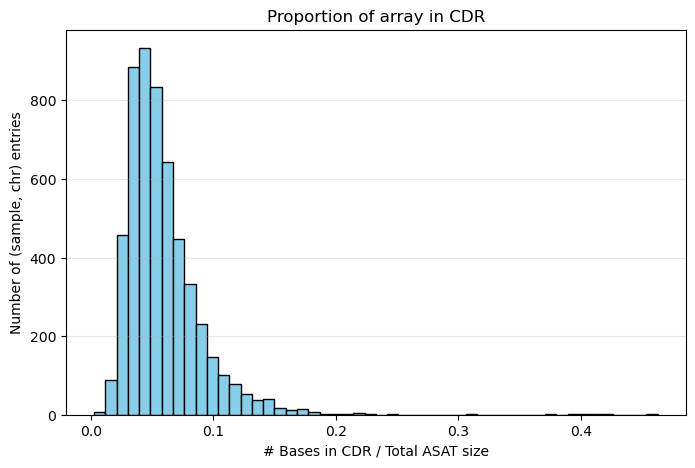

In [64]:
import matplotlib.pyplot as plt

# Compute proportions
proportions = []
for key in real_cdr_intervals:
    if key not in asat_bounds:
        continue
    cdrs = real_cdr_intervals[key]
    bounds_start, bounds_end = asat_bounds[key]
    total_cdr_bases = sum(end - start for start, end in cdrs)
    total_bounds_bases = bounds_end - bounds_start
    proportions.append(total_cdr_bases / total_bounds_bases)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(proportions, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("# Bases in CDR / Total ASAT size")
plt.ylabel("Number of (sample, chr) entries")
plt.title("Proportion of array in CDR")
plt.grid(axis='y', alpha=0.3)
plt.show()


In [55]:
print(asat_bounds)

{('HG02572.1', 'chr2'): (92088720, 94028031), ('HG02572.1', 'chr7'): (60815527, 63871369), ('HG02572.1', 'chr8'): (44232206, 46352903), ('HG02572.1', 'chr9'): (42616238, 44955099), ('HG02572.1', 'chr11'): (50957725, 52118575), ('HG02572.1', 'chr13'): (11342848, 12879738), ('HG02572.1', 'chr14'): (10697072, 13860919), ('HG02572.1', 'chr15'): (7702020, 8601968), ('HG02572.1', 'chr16'): (34100966, 36081983), ('HG02572.1', 'chr19'): (25539653, 28704245), ('HG02572.1', 'chr20'): (27363618, 30021264), ('HG02572.1', 'chr21'): (5075354, 7241107), ('HG02572.1', 'chrY'): (9860231, 10751486), ('HG02572.1', 'chr3'): (91828348, 95558641), ('HG03470.1', 'chr1'): (121482871, 124951682), ('HG03470.1', 'chr2'): (92654212, 94441165), ('HG03470.1', 'chr7'): (60551641, 63172672), ('HG03470.1', 'chr8'): (43798429, 45937883), ('HG03470.1', 'chr9'): (44940753, 47630217), ('HG03470.1', 'chr10'): (39587882, 41368607), ('HG03470.1', 'chr11'): (50958731, 55095717), ('HG03470.1', 'chr12'): (34670641, 37697004), (

In [51]:
## Debug chr 4 

real = [(50902094, 51005470), (51016194, 51064291), (51108649, 51123112), (51191112, 52559454)]
bounds = (49946033, 53263026)
rng = np.random.default_rng(42)

random_intervals_like(
                real_intervals=real,
                bounds=bounds,
                rng=rng)

[(np.int64(50232851), np.int64(50336227)),
 (np.int64(50338627), np.int64(51706969)),
 (np.int64(52107775), np.int64(52122238)),
 (np.int64(52476015), np.int64(52524112))]